In [7]:
import matplotlib.pyplot as plt
import sys
sys.path.append("/data/home/guntherxing/dev/spdk/exp/plot")
from utils import *
import pandas as pd
import shutil
import os

In [8]:
result_target = "/data/home/guntherxing/dev/spdk/exp/result/random_group"
result_files = os.listdir(result_target)
result_files = [os.path.join(result_target, f) for f in result_files]
print(result_files)

IO_ITEMS = ["USER", "COMPACTION", "BASE_MD", "NVC_MD", "L2P"]

['/data/home/guntherxing/dev/spdk/exp/result/random_group/4k_seq_op60.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/128k_rand_op60.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/128k_seq_op60.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/16k_seq_op20.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/16k_rand_op20.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/4k_seq_op20.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/16k_rand_op60.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/4k_rand_op60.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/128k_seq_op40.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/16k_seq_op40.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/4k_seq_op40.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/128k_seq_op20.log', '/data/home/guntherxing/dev/spdk/exp/result/random_group/4k_rand_op40.log', '/data/

In [9]:
def plot_io(result_file, metric, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    read_metric_dict = {}
    write_metric_dict = {}
    for item in IO_ITEMS:
        stat = extract_stat_io(result_file, item)
        read_metric_dict[item] = stat[f"read_{metric}"]
        write_metric_dict[item] = stat[f"write_{metric}"]

    read_metric_df = pd.DataFrame(read_metric_dict)
    write_metric_df = pd.DataFrame(write_metric_dict)
    read_metric_df.to_csv(os.path.join(save_dir, f"read_{metric}.csv"))
    read_metric_df = read_metric_df[int(0.1*read_metric_df.shape[0]):int(0.9*read_metric_df.shape[0])]
    plt.clf()
    plt.xlabel("Time (s)")
    if metric == "bw":
        plt.ylabel("Bandwidth (MB/s)")
    else:
        plt.ylabel("IOPS")
    read_metric_df.plot()
    plt.savefig(os.path.join(save_dir, f"read_{metric}.pdf"))
    write_metric_df.to_csv(os.path.join(save_dir, f"write_{metric}.csv"))
    write_metric_df = write_metric_df[int(0.1*write_metric_df.shape[0]):int(0.9*write_metric_df.shape[0])]
    plt.clf()
    plt.xlabel("Time (s)")
    if metric == "bw":
        plt.ylabel("Bandwidth (MB/s)")
    else:
        plt.ylabel("IOPS")
    write_metric_df.plot()
    plt.savefig(os.path.join(save_dir, f"write_{metric}.pdf"))
    

In [10]:
def plot_stat_waf(result_file, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    stat = extract_stat_waf(result_file)
    stat_df = pd.DataFrame(stat)
    stat_df.to_csv(os.path.join(save_dir, "stat_waf.csv"))
    stat_df = stat_df[int(0.1*stat_df.shape[0]):int(0.9*stat_df.shape[0])]
    plt.clf()
    stat_df.plot()
    plt.xlabel("Time (s)")
    plt.ylabel("WAF")
    plt.savefig(os.path.join(save_dir, "stat_waf.pdf"))

In [11]:
def plot_overall_waf(result_file, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    waf, final_waf = extract_overall_waf(result_file)
    stat_df = pd.DataFrame(waf)
    stat_df.to_csv(os.path.join(save_dir, "overall_waf.csv"))
    stat_df = stat_df[int(0.1*stat_df.shape[0]):int(0.9*stat_df.shape[0])]
    plt.clf()
    plt.xlabel("Time (s)")
    plt.ylabel("WAF")
    stat_df.plot()
    plt.savefig(os.path.join(save_dir, "overall_waf.pdf"))
    return waf, final_waf

/data/home/guntherxing/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


            algo                   f    IOPS  BW(MB/S)  latency  final_waf
0   random_group     4k_seq_op60.log  288000    1178.0   439.24     1.0000
1   random_group  128k_rand_op60.log   20000    2622.0  6398.03     1.1162
2   random_group   128k_seq_op60.log   22100    2902.0  5781.34     1.0000
3   random_group    16k_seq_op20.log  142000    2329.0   899.64     1.0000
4   random_group   16k_rand_op20.log   44100     723.0  2899.85     2.8470
5   random_group     4k_seq_op20.log  267000    1094.0   473.41     1.0000
6   random_group   16k_rand_op60.log  140000    2301.0   909.35     1.1127
7   random_group    4k_rand_op60.log  278000    1140.0   455.92     1.0000
8   random_group   128k_seq_op40.log   22100    2895.0  5794.96     1.0000
9   random_group    16k_seq_op40.log  146000    2389.0   877.06     1.0000
10  random_group     4k_seq_op40.log  289000    1183.0   437.25     1.0000
11  random_group   128k_seq_op20.log   22200    2907.0  5770.16     1.0002
12  random_group    4k_ra

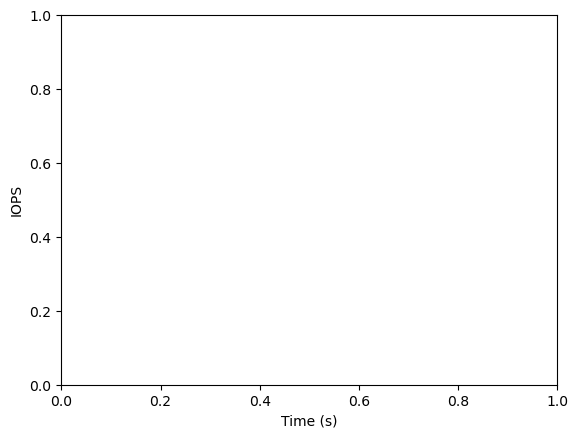

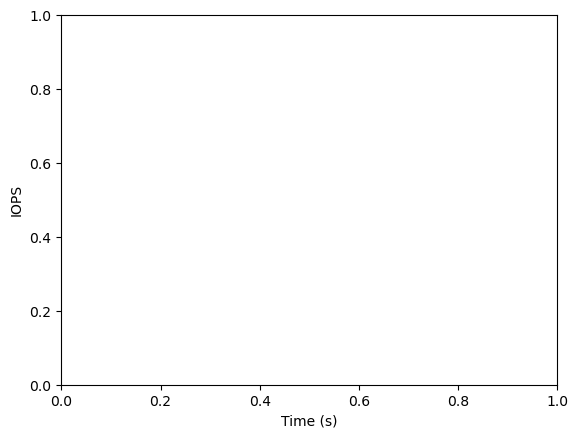

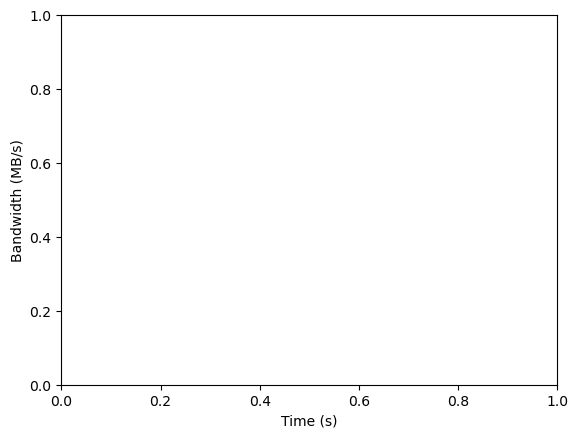

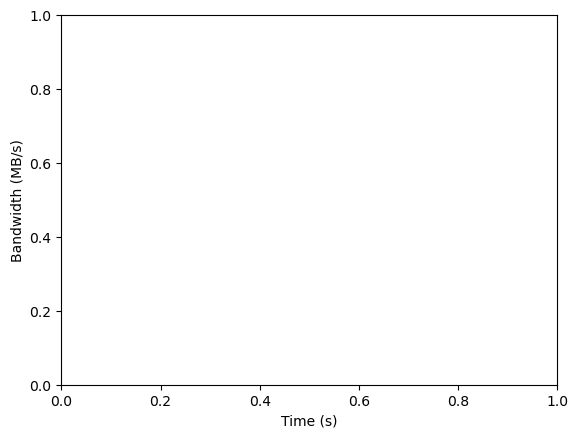

<Figure size 640x480 with 0 Axes>

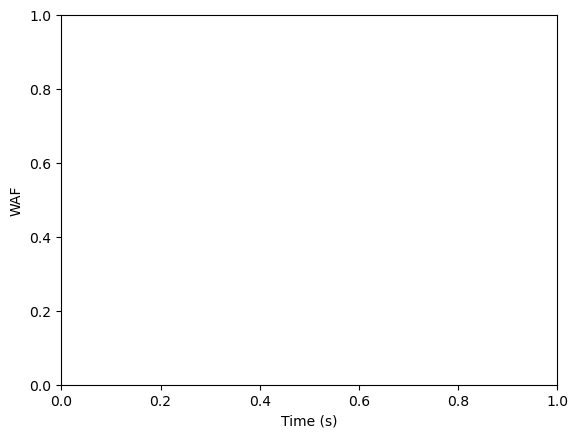

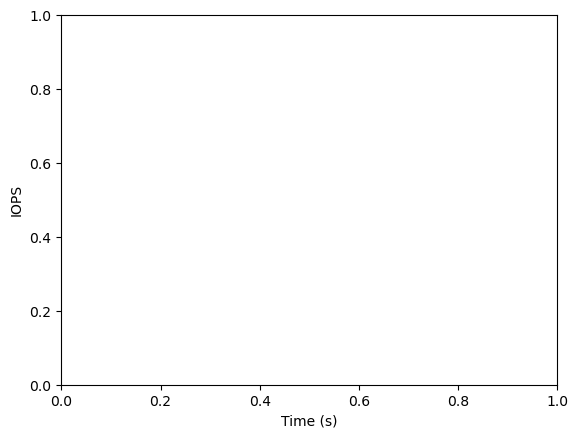

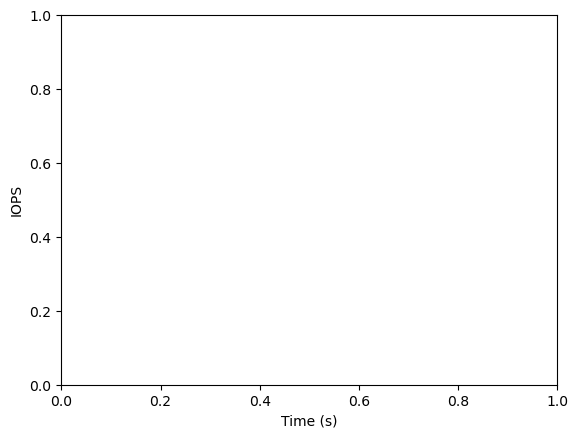

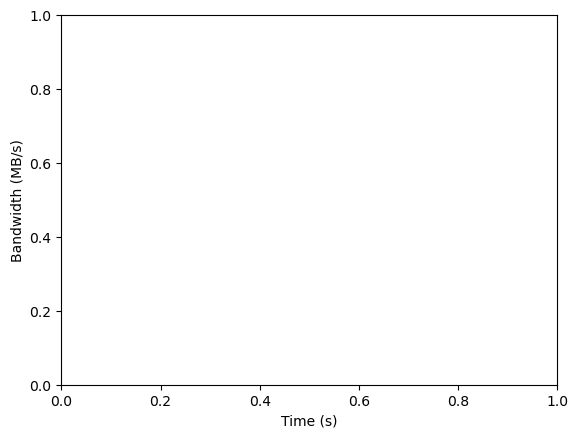

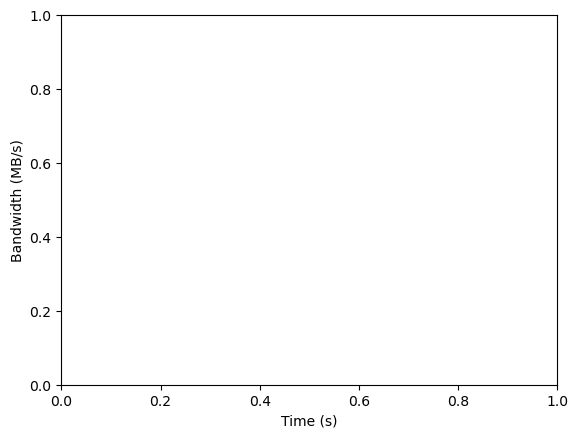

<Figure size 640x480 with 0 Axes>

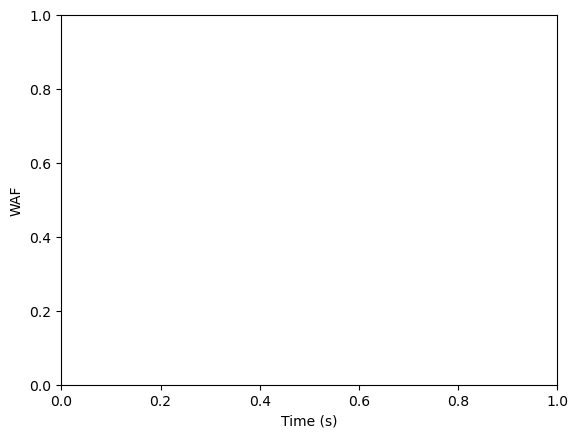

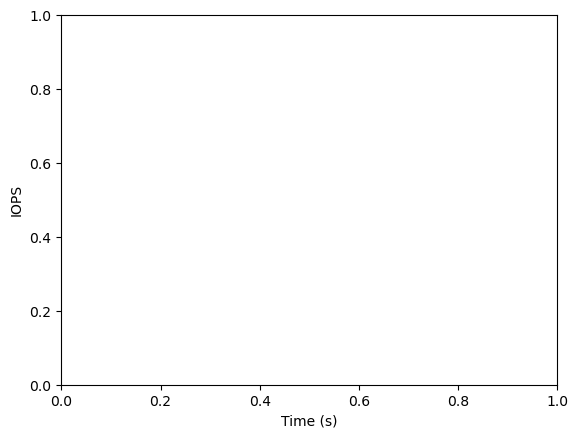

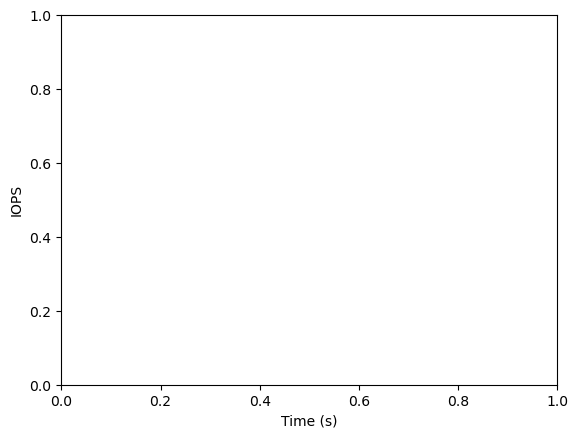

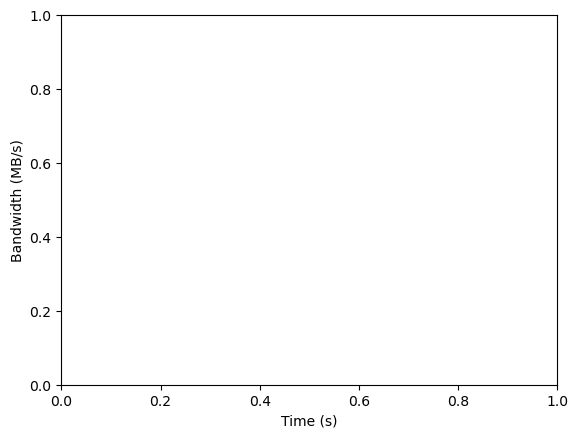

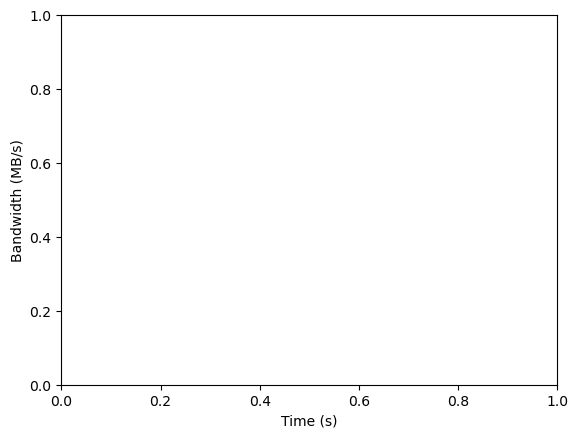

<Figure size 640x480 with 0 Axes>

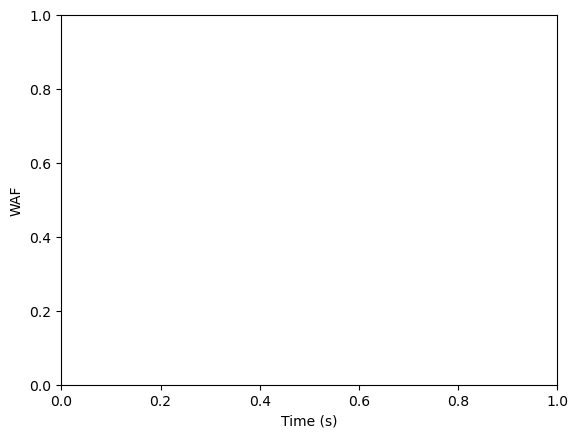

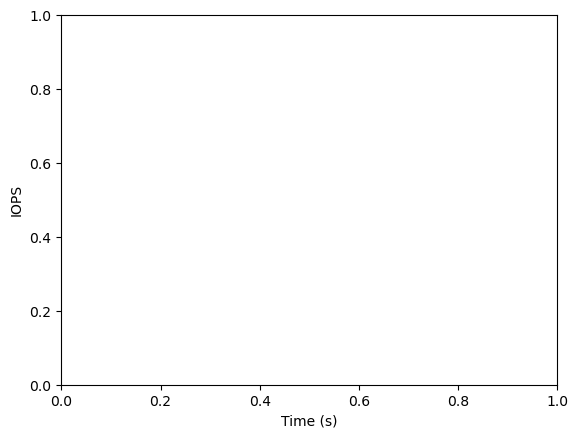

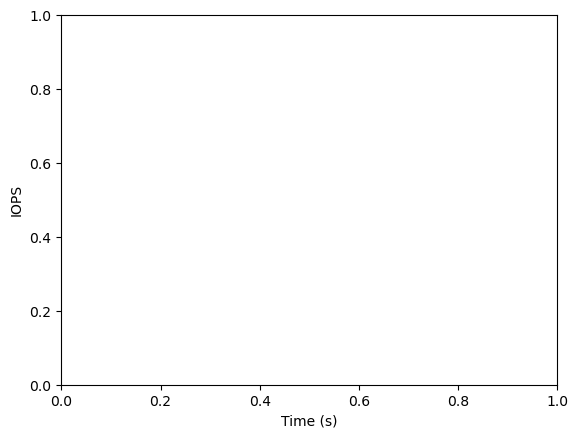

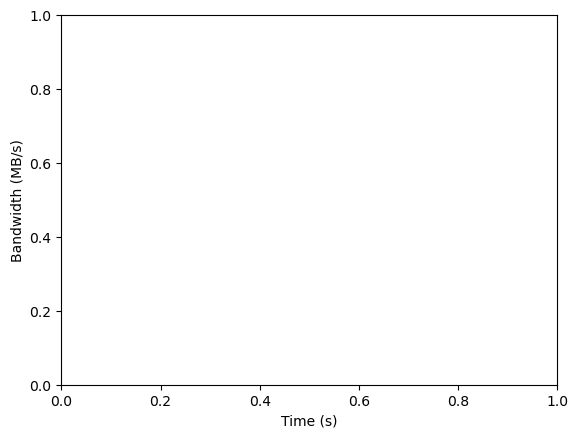

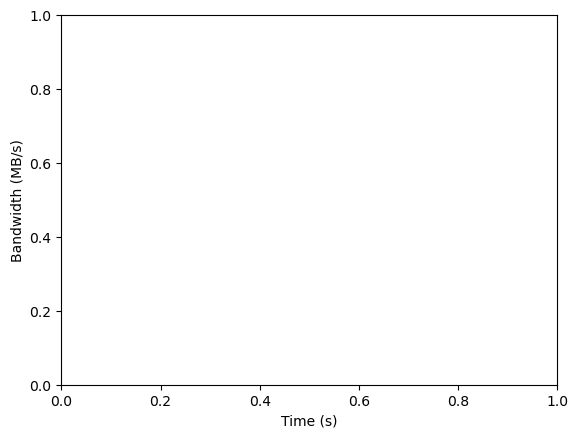

<Figure size 640x480 with 0 Axes>

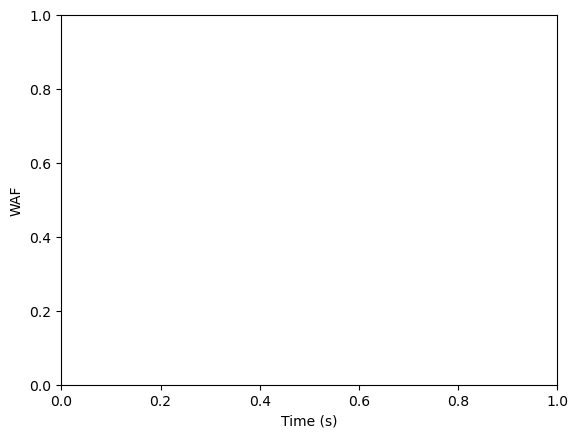

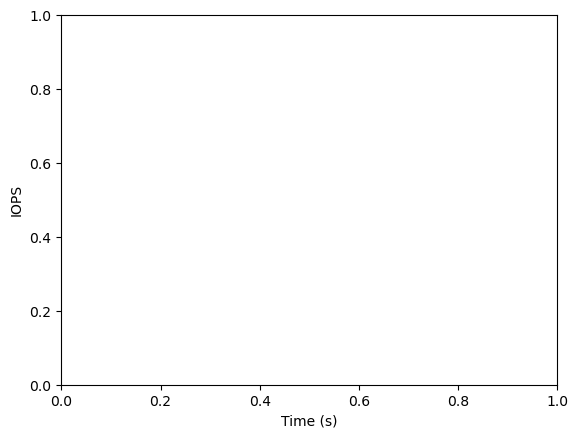

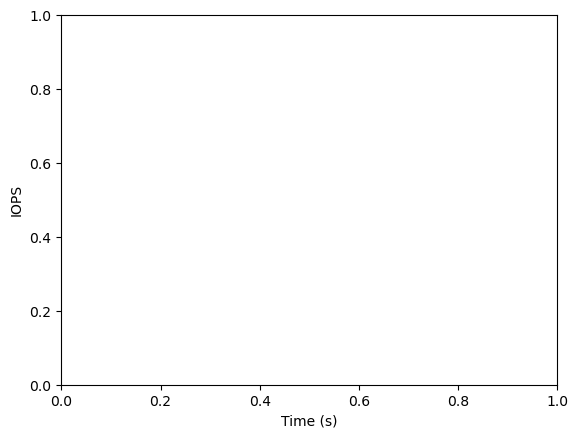

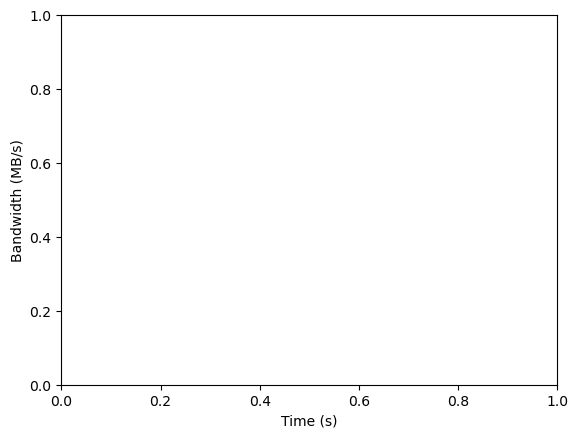

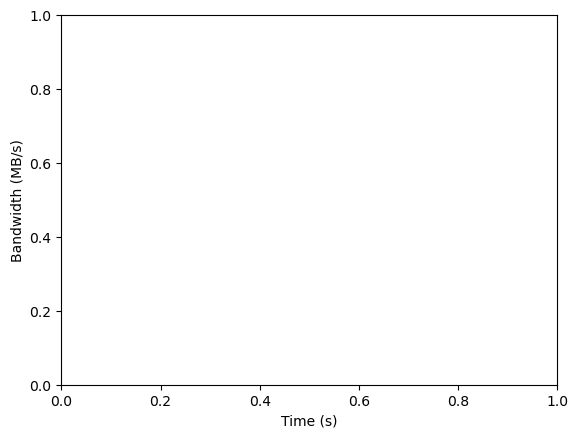

<Figure size 640x480 with 0 Axes>

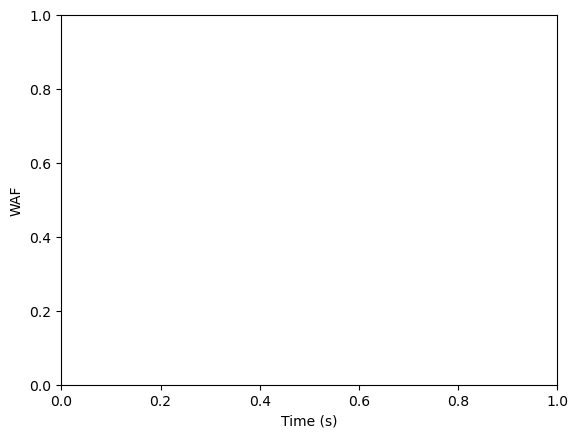

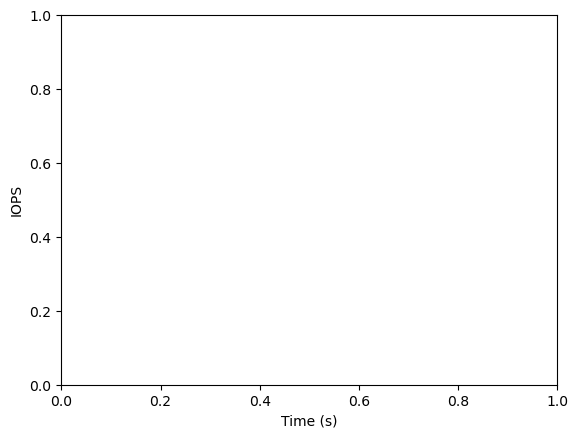

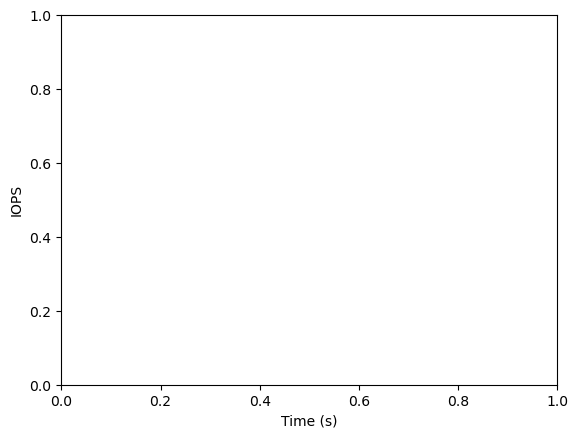

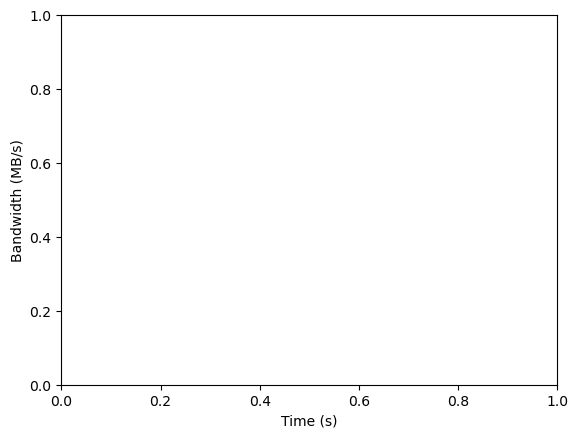

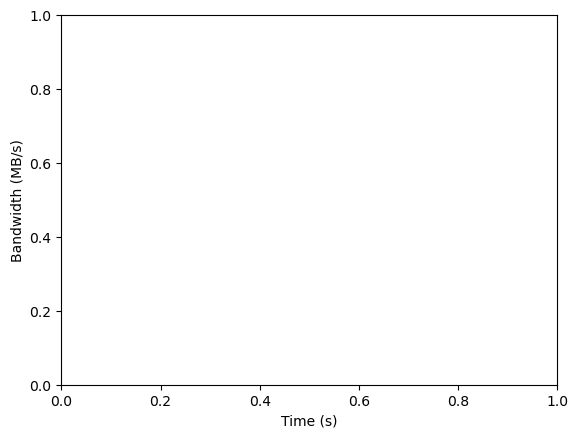

<Figure size 640x480 with 0 Axes>

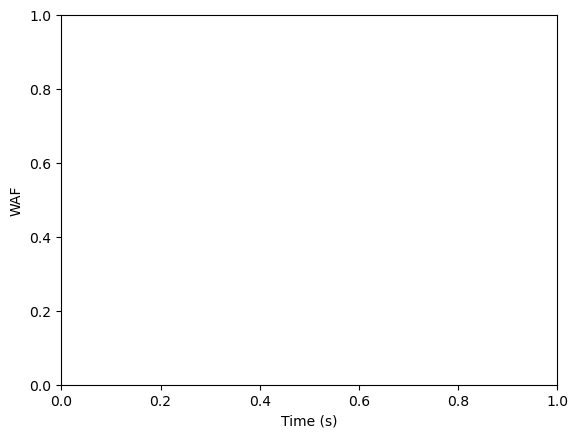

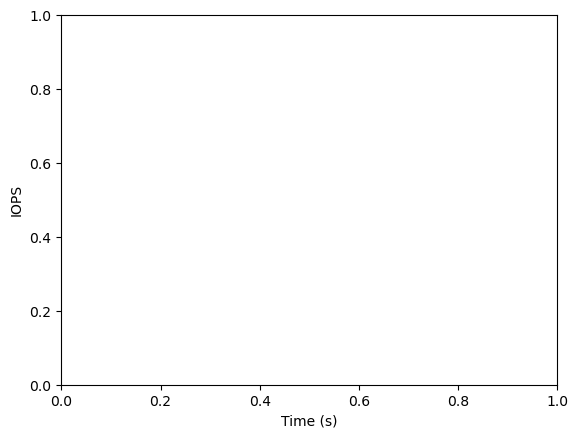

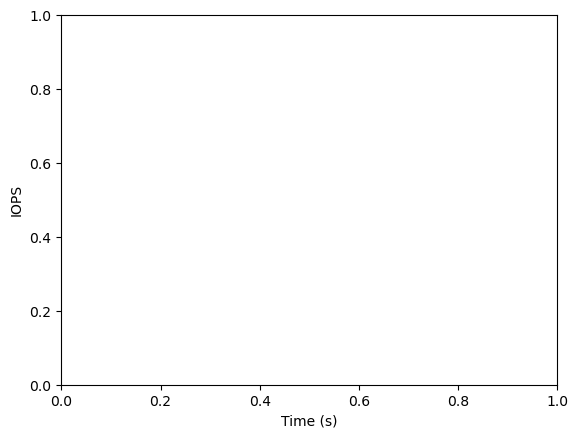

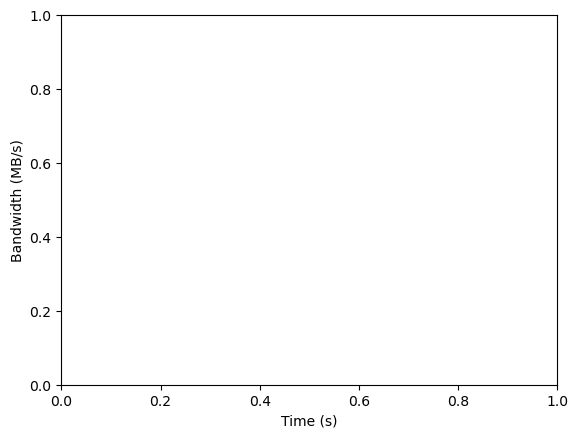

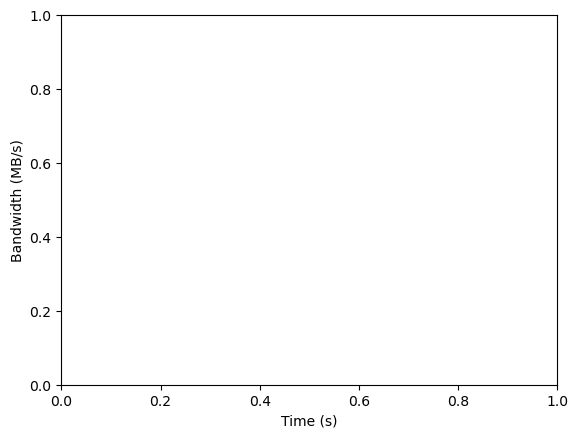

<Figure size 640x480 with 0 Axes>

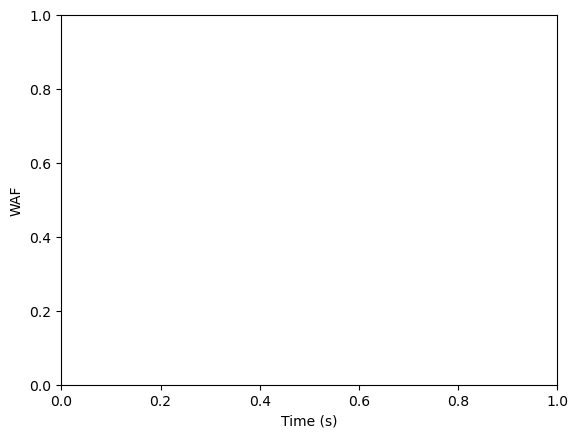

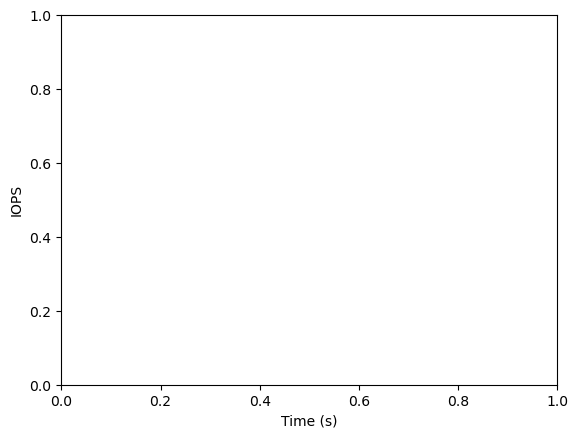

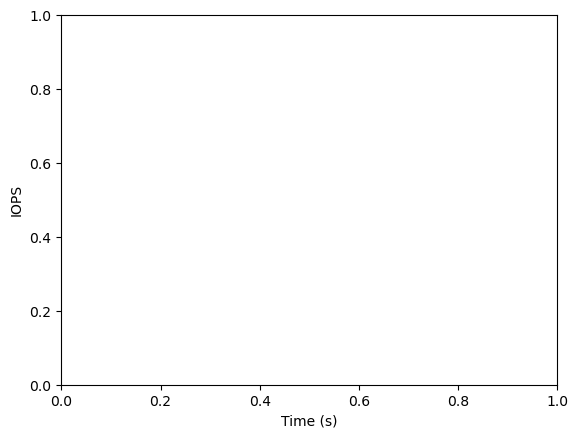

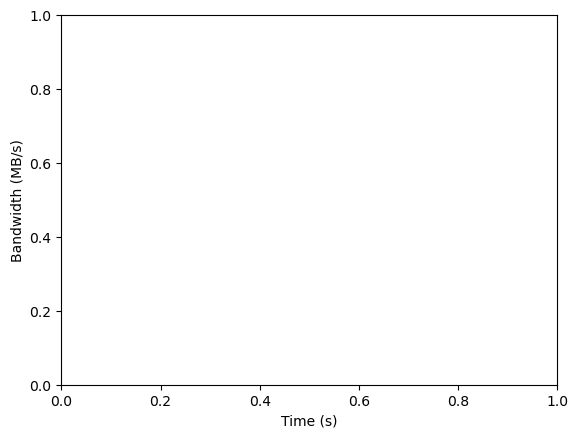

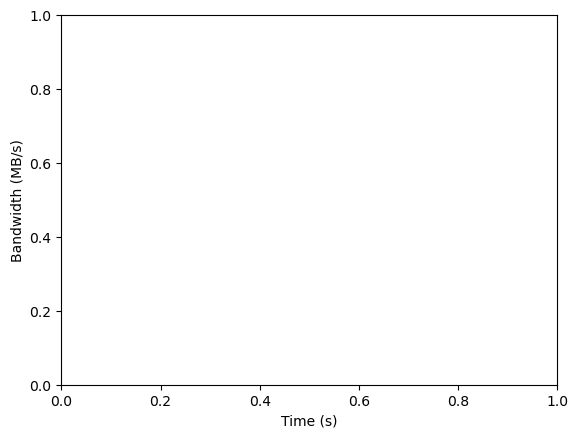

<Figure size 640x480 with 0 Axes>

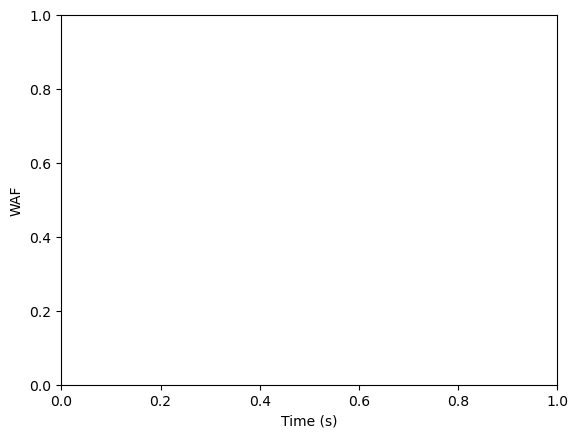

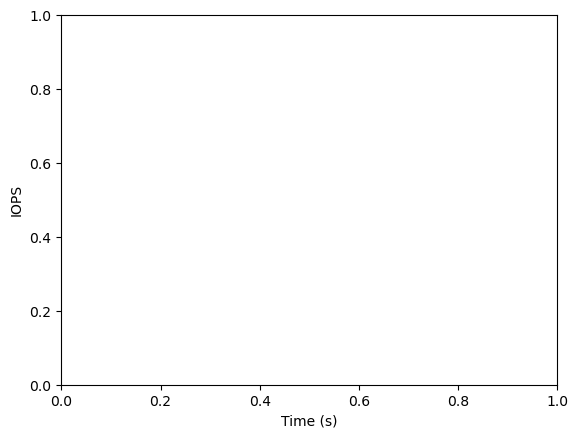

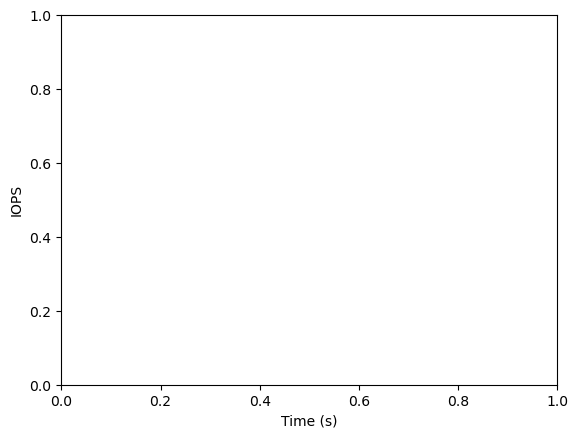

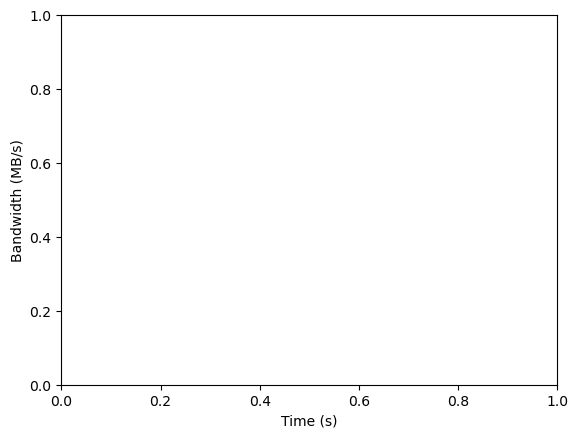

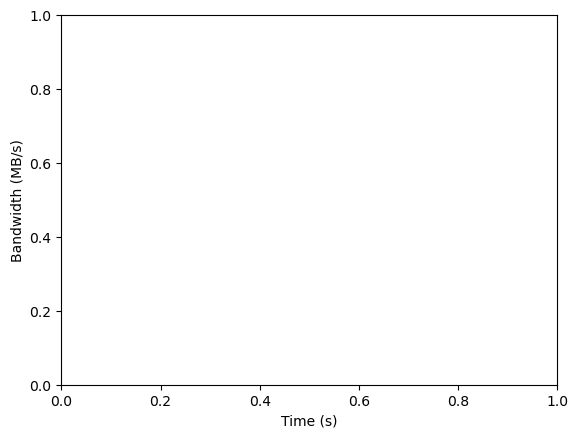

<Figure size 640x480 with 0 Axes>

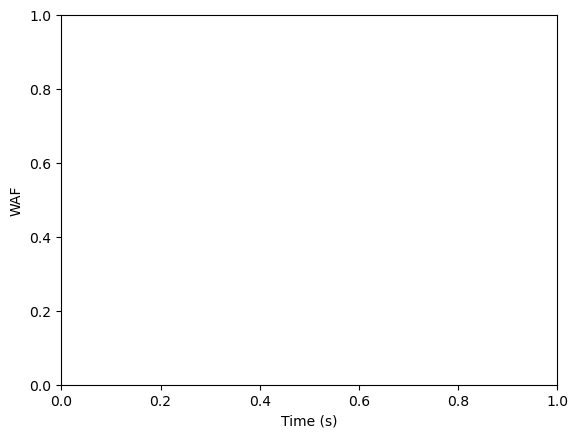

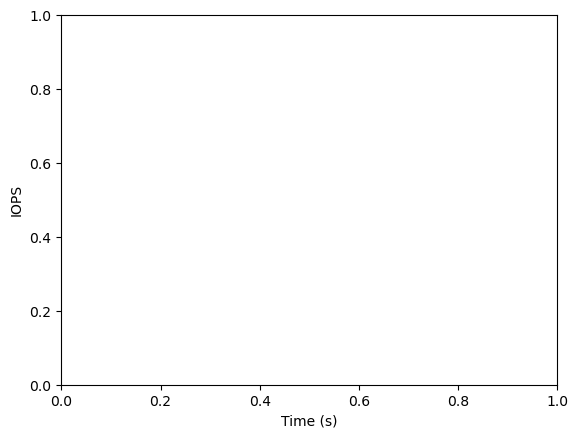

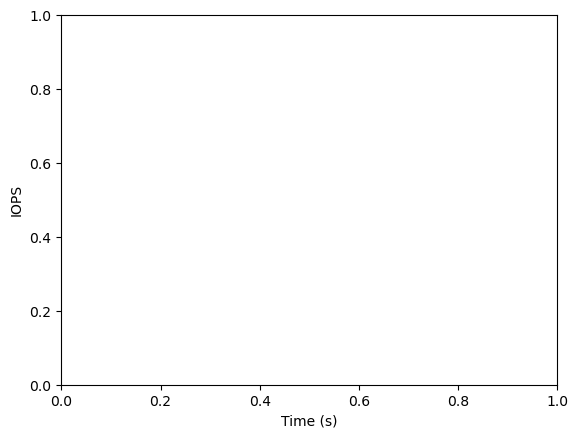

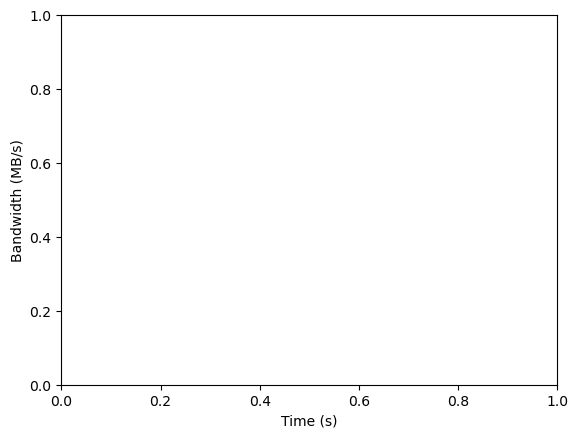

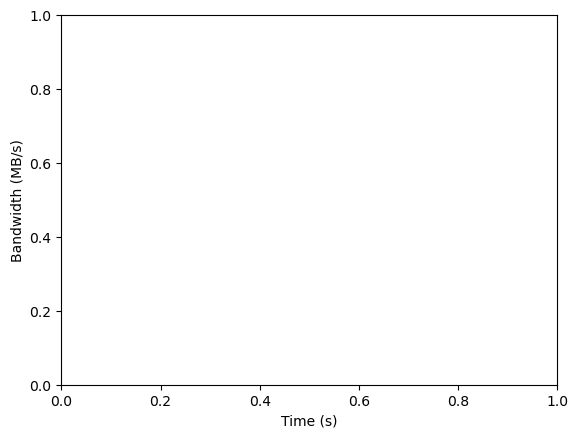

<Figure size 640x480 with 0 Axes>

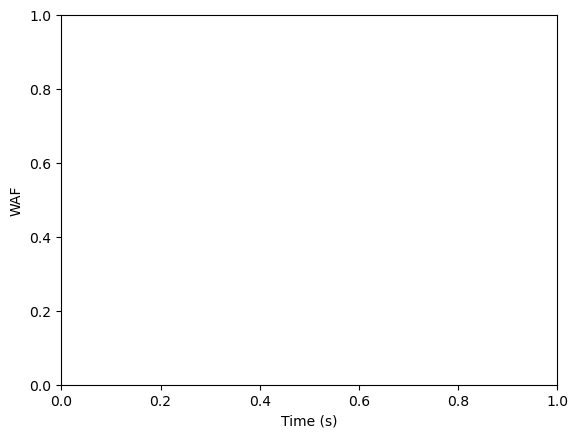

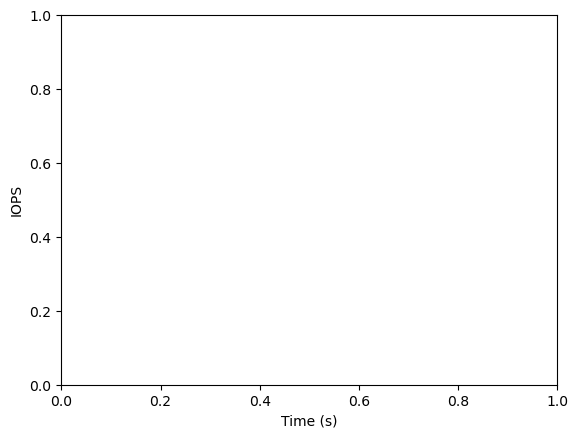

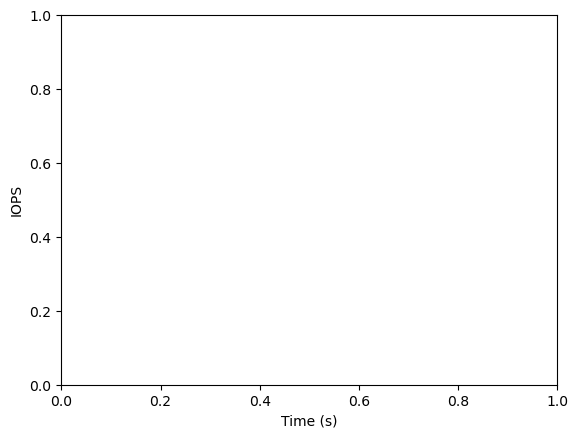

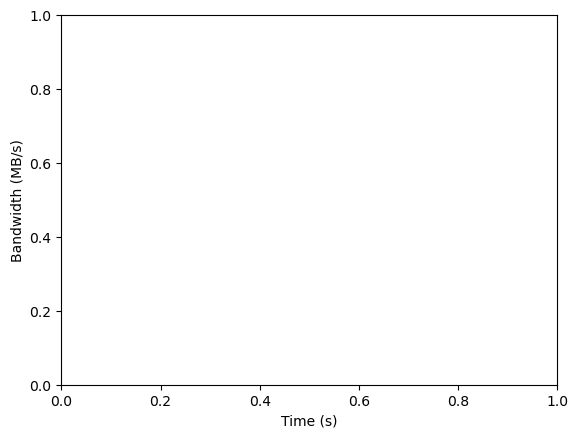

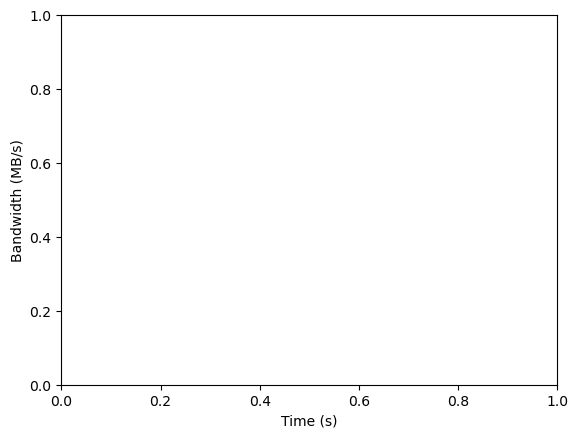

<Figure size 640x480 with 0 Axes>

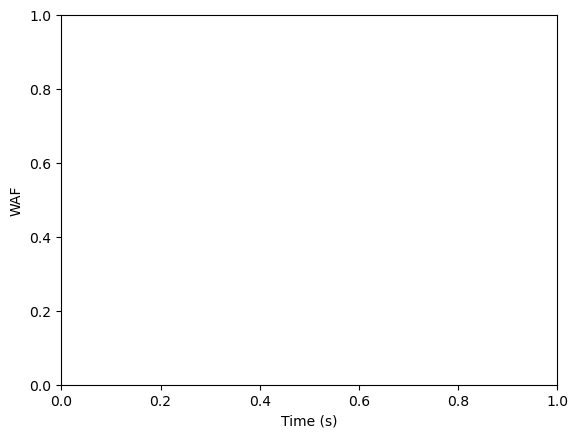

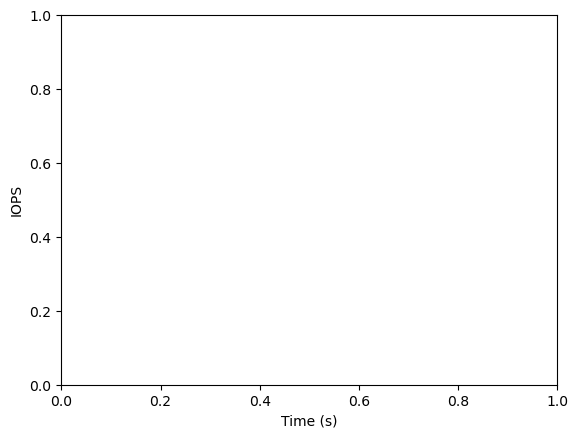

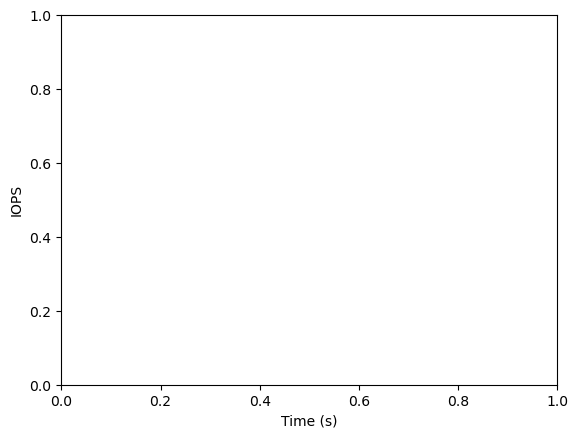

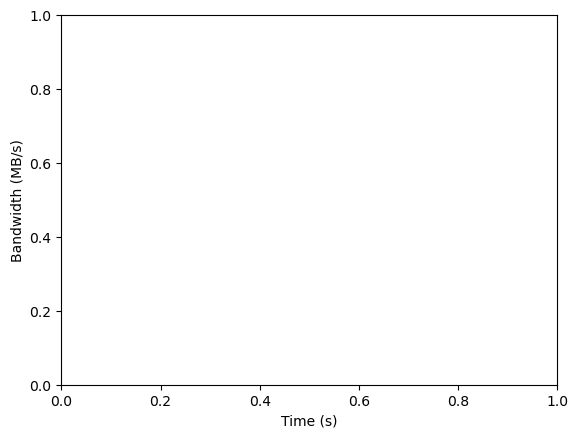

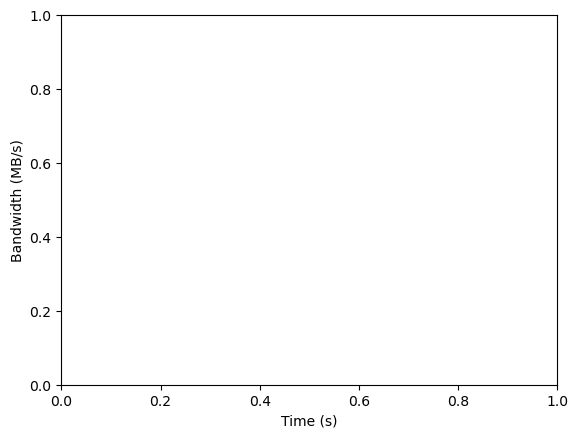

<Figure size 640x480 with 0 Axes>

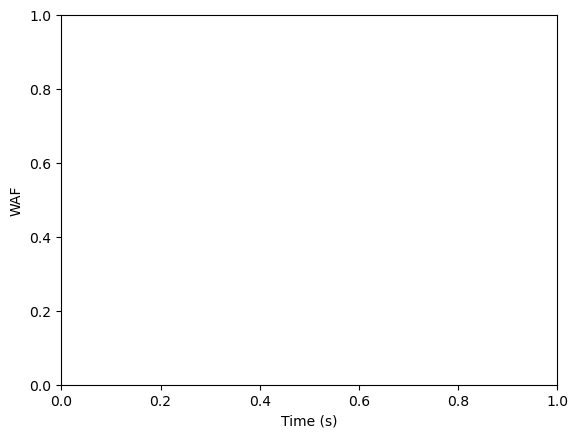

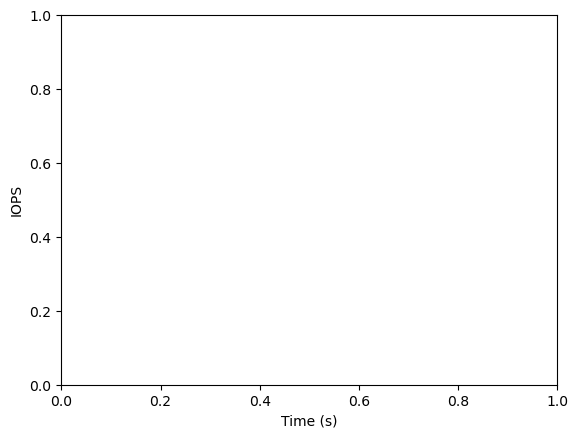

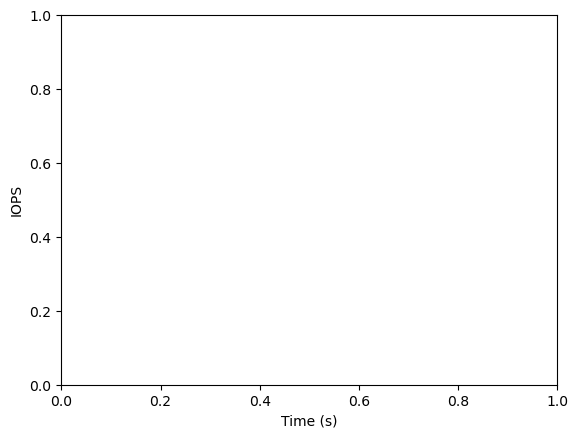

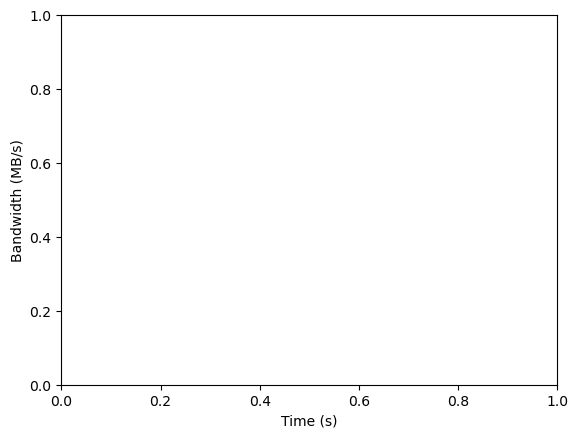

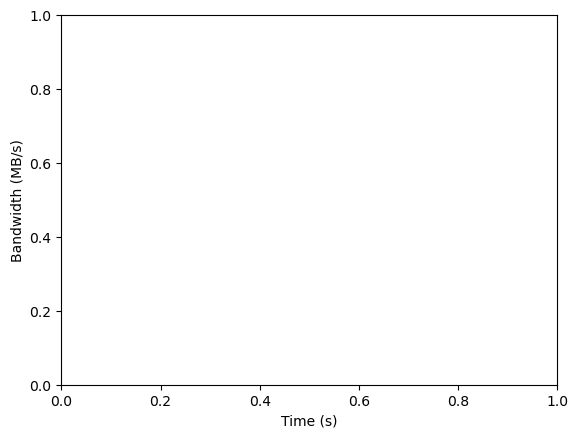

<Figure size 640x480 with 0 Axes>

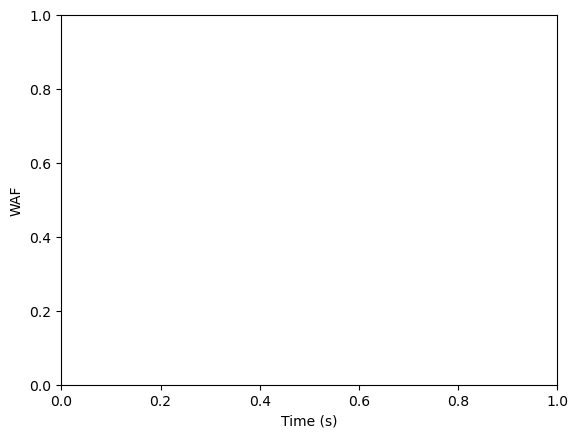

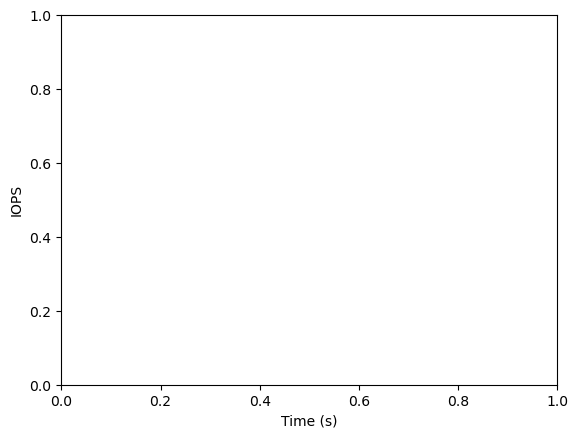

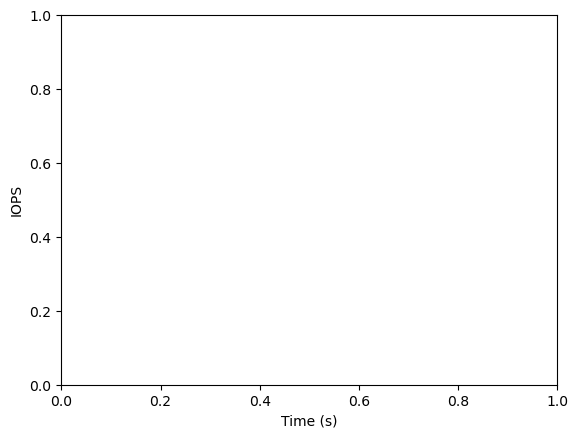

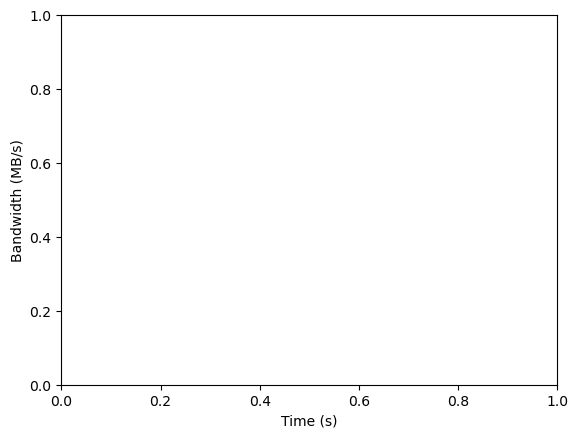

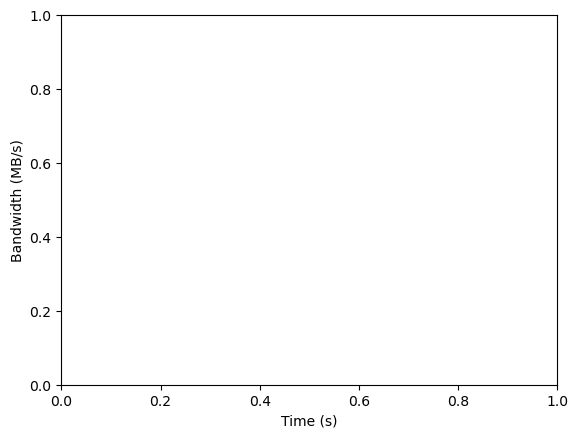

<Figure size 640x480 with 0 Axes>

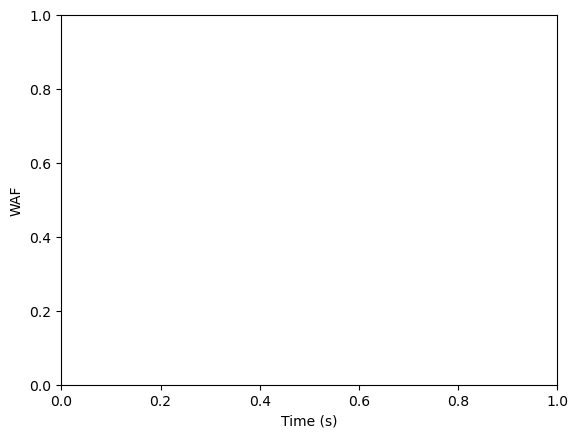

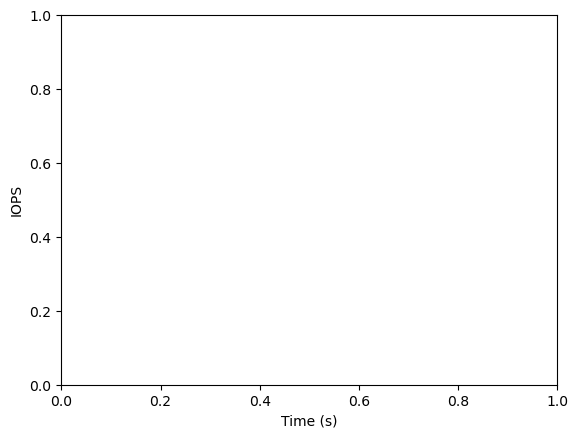

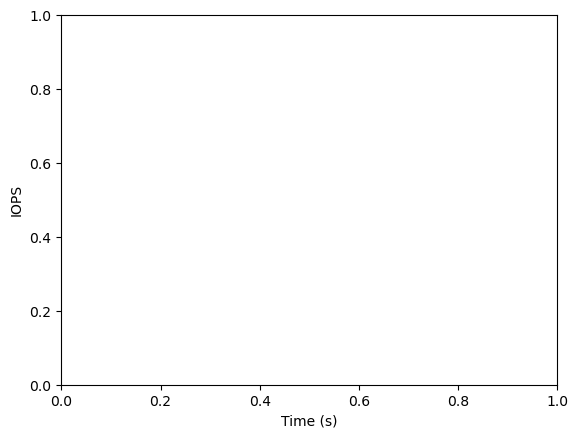

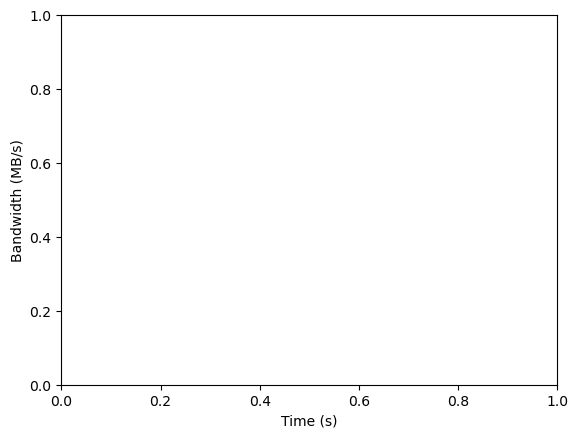

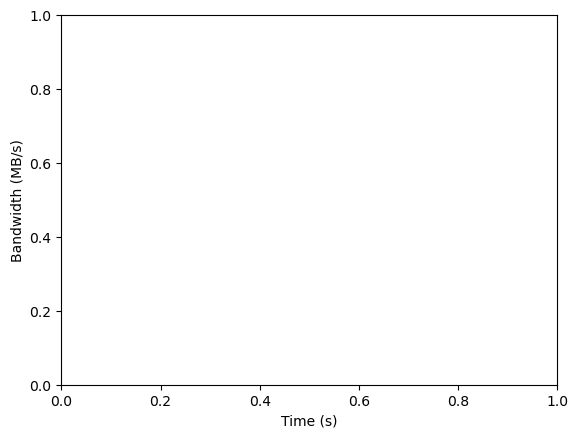

<Figure size 640x480 with 0 Axes>

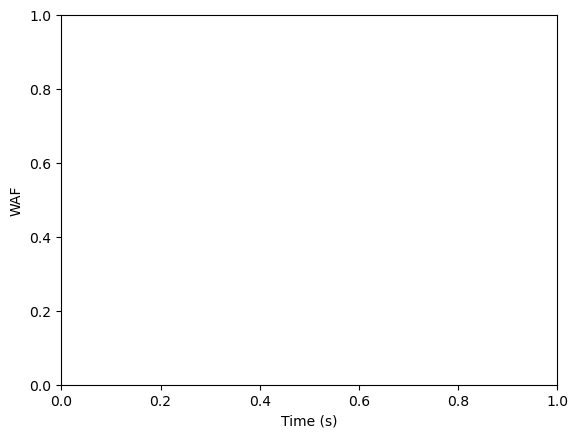

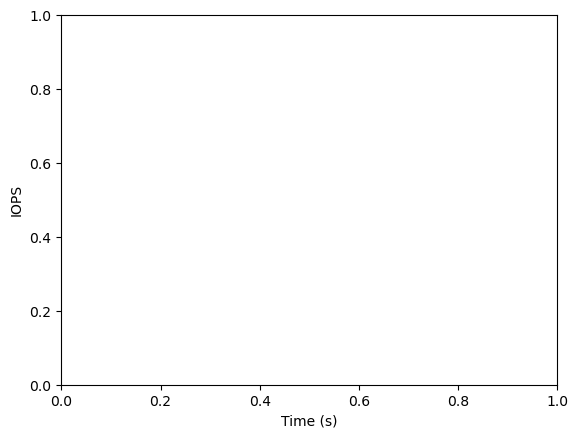

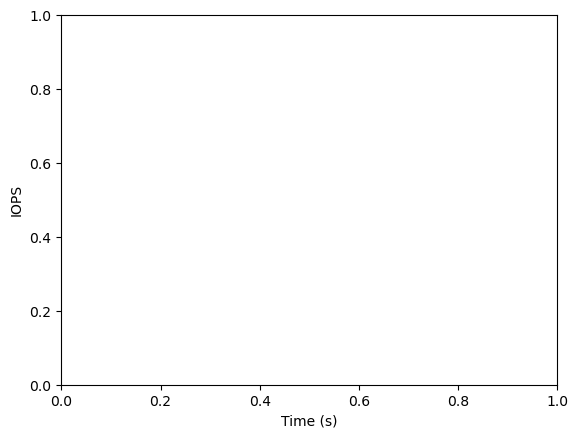

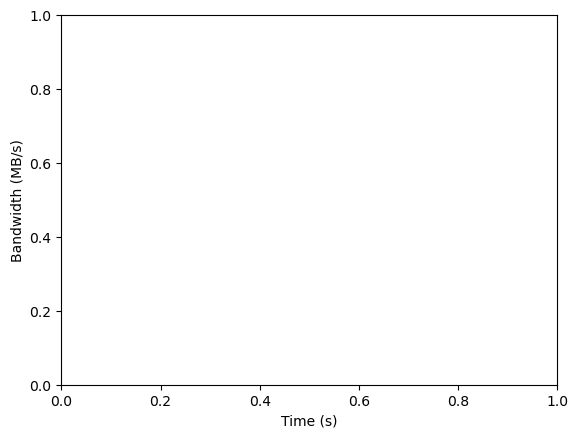

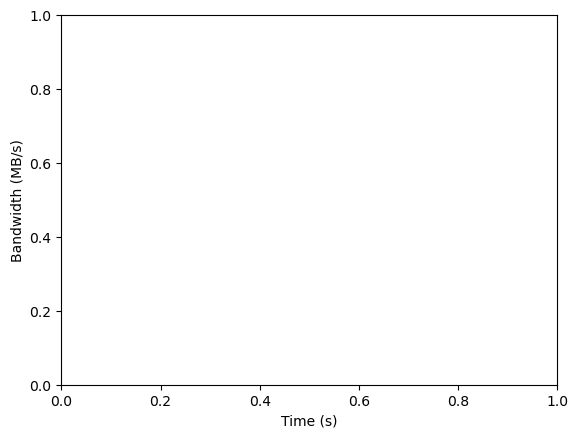

<Figure size 640x480 with 0 Axes>

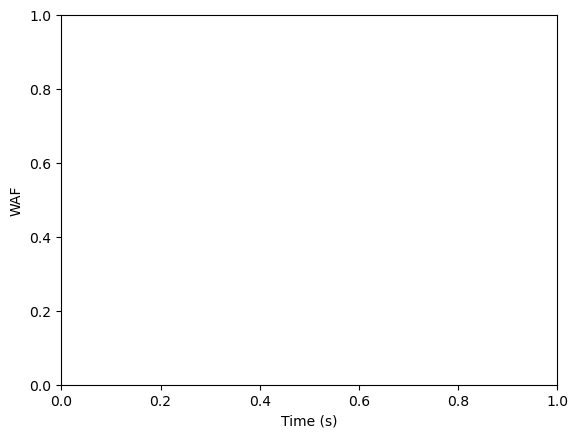

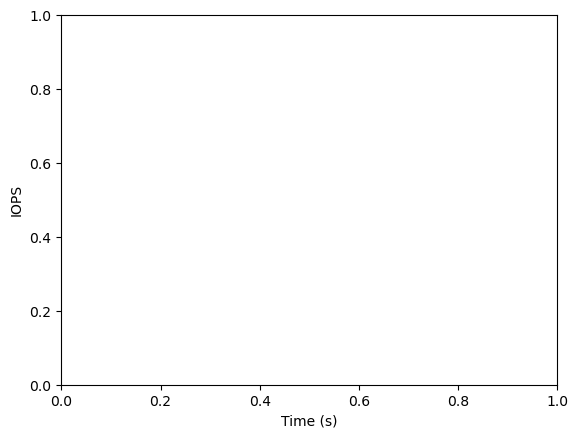

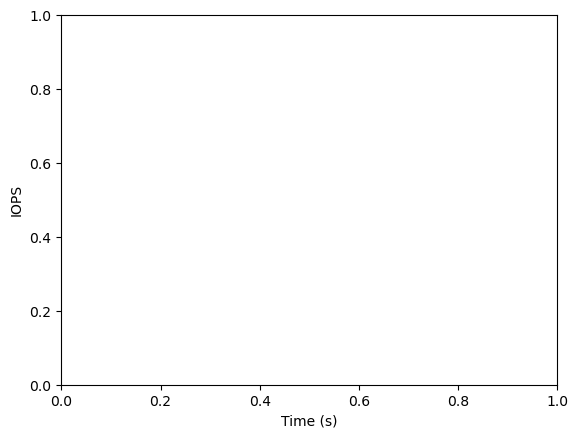

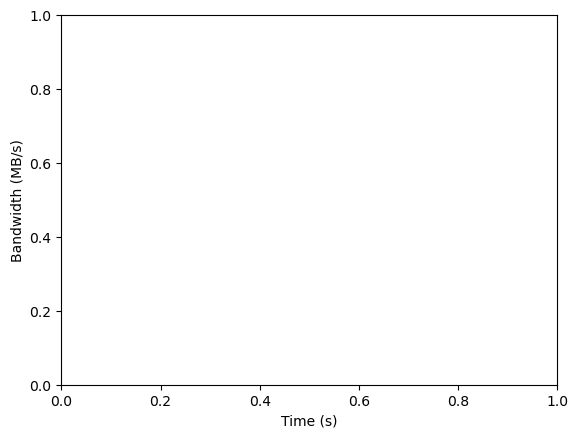

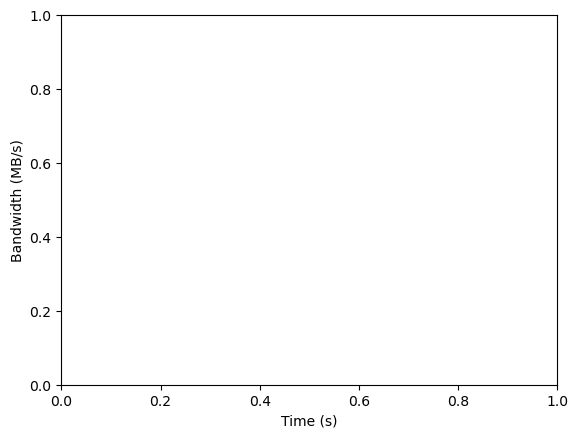

<Figure size 640x480 with 0 Axes>

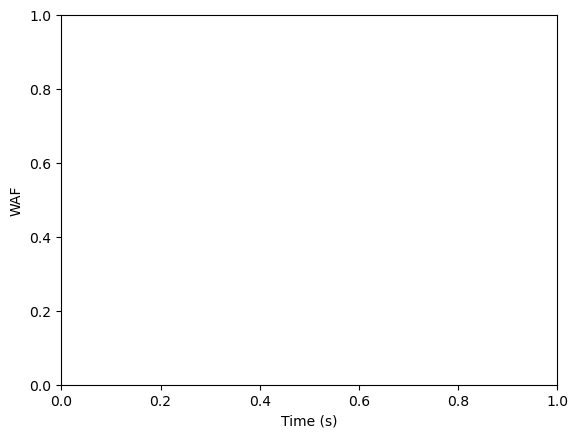

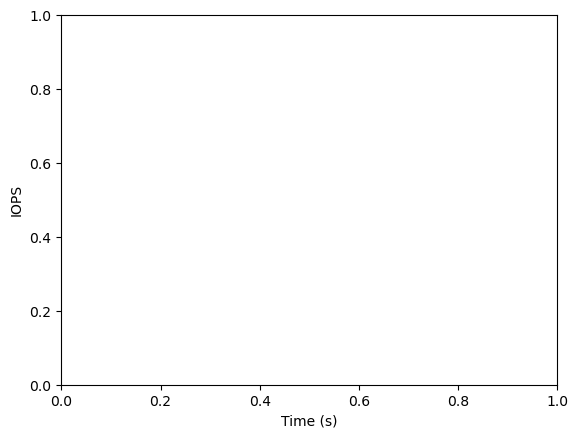

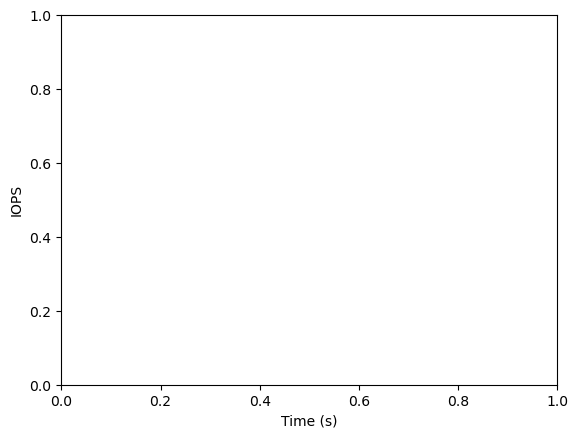

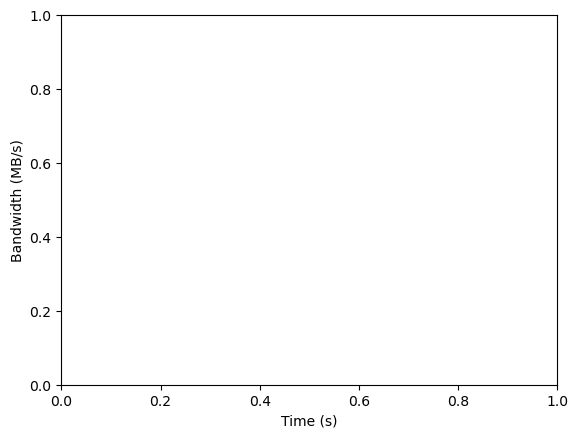

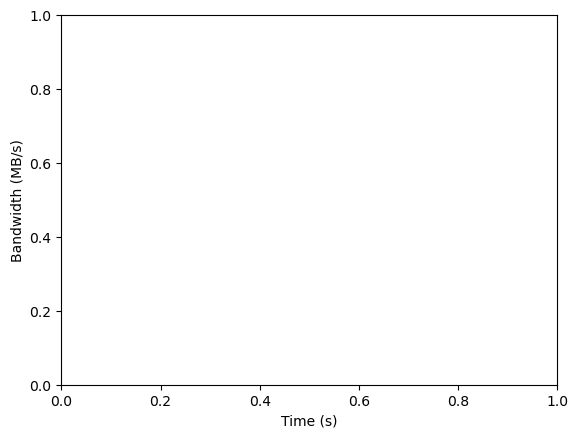

<Figure size 640x480 with 0 Axes>

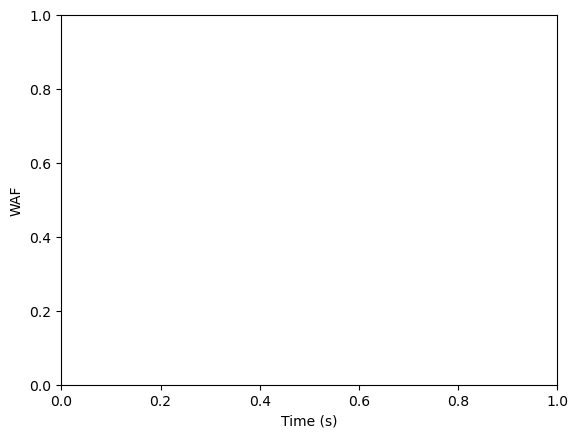

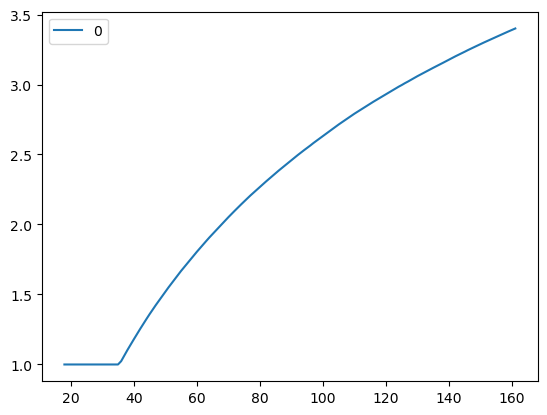

In [12]:
result_dics = []
for result_f in result_files:
    try:
        core_result_f = dump_core_log(result_f)
        algo, f = result_f.split(os.sep)[-2:]
        save_dir = os.path.join("/data/home/guntherxing/dev/spdk/exp/plot", os.sep.join([algo, f]))
        for metric in ["IOPS", "bw"]:
            plot_io(core_result_f, metric, save_dir)
        plot_stat_waf(core_result_f, save_dir)
        _, final_waf = plot_overall_waf(core_result_f, save_dir)
        iops, bw, latency = extract_fio(result_f)

        result_dics.append({
            "algo": algo,
            "f": f,
            "IOPS": iops,
            "BW(MB/S)": bw,
            "latency": latency,
            "final_waf": final_waf,
        })
    except Exception as e:
        print(f"Error: {e}")
    finally:
        os.remove(core_result_f)
result_df = pd.DataFrame(result_dics)
print(result_df)
result_df.to_csv(os.path.join("/data/home/guntherxing/dev/spdk/exp/result", "result.csv"))